# Neural networks applied to OCR

OCR with NN

In [1]:
# Set up imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

## Read OCR dataset


In [2]:
def make_output(letter):
    """Convert a capital letter into the a binary expression
       to be used as output of the NN"""
    output= [ float(c) for c in "{:05b}".format(ord(letter)-65) ]
    return output

# Read OCR dataset
dataset = pd.read_csv("letter-recognition.txt", header=None).values

# Generate output
output= np.array([ make_output(c) for c in dataset[:,0] ])

# Stack output to data
# dataset= np.hstack( (dataset,output) )

# Delete first column (letter)
dataset= np.delete(dataset,0,1) 

# Convert to float (required by tensorflow)
dataset= dataset.astype(float)

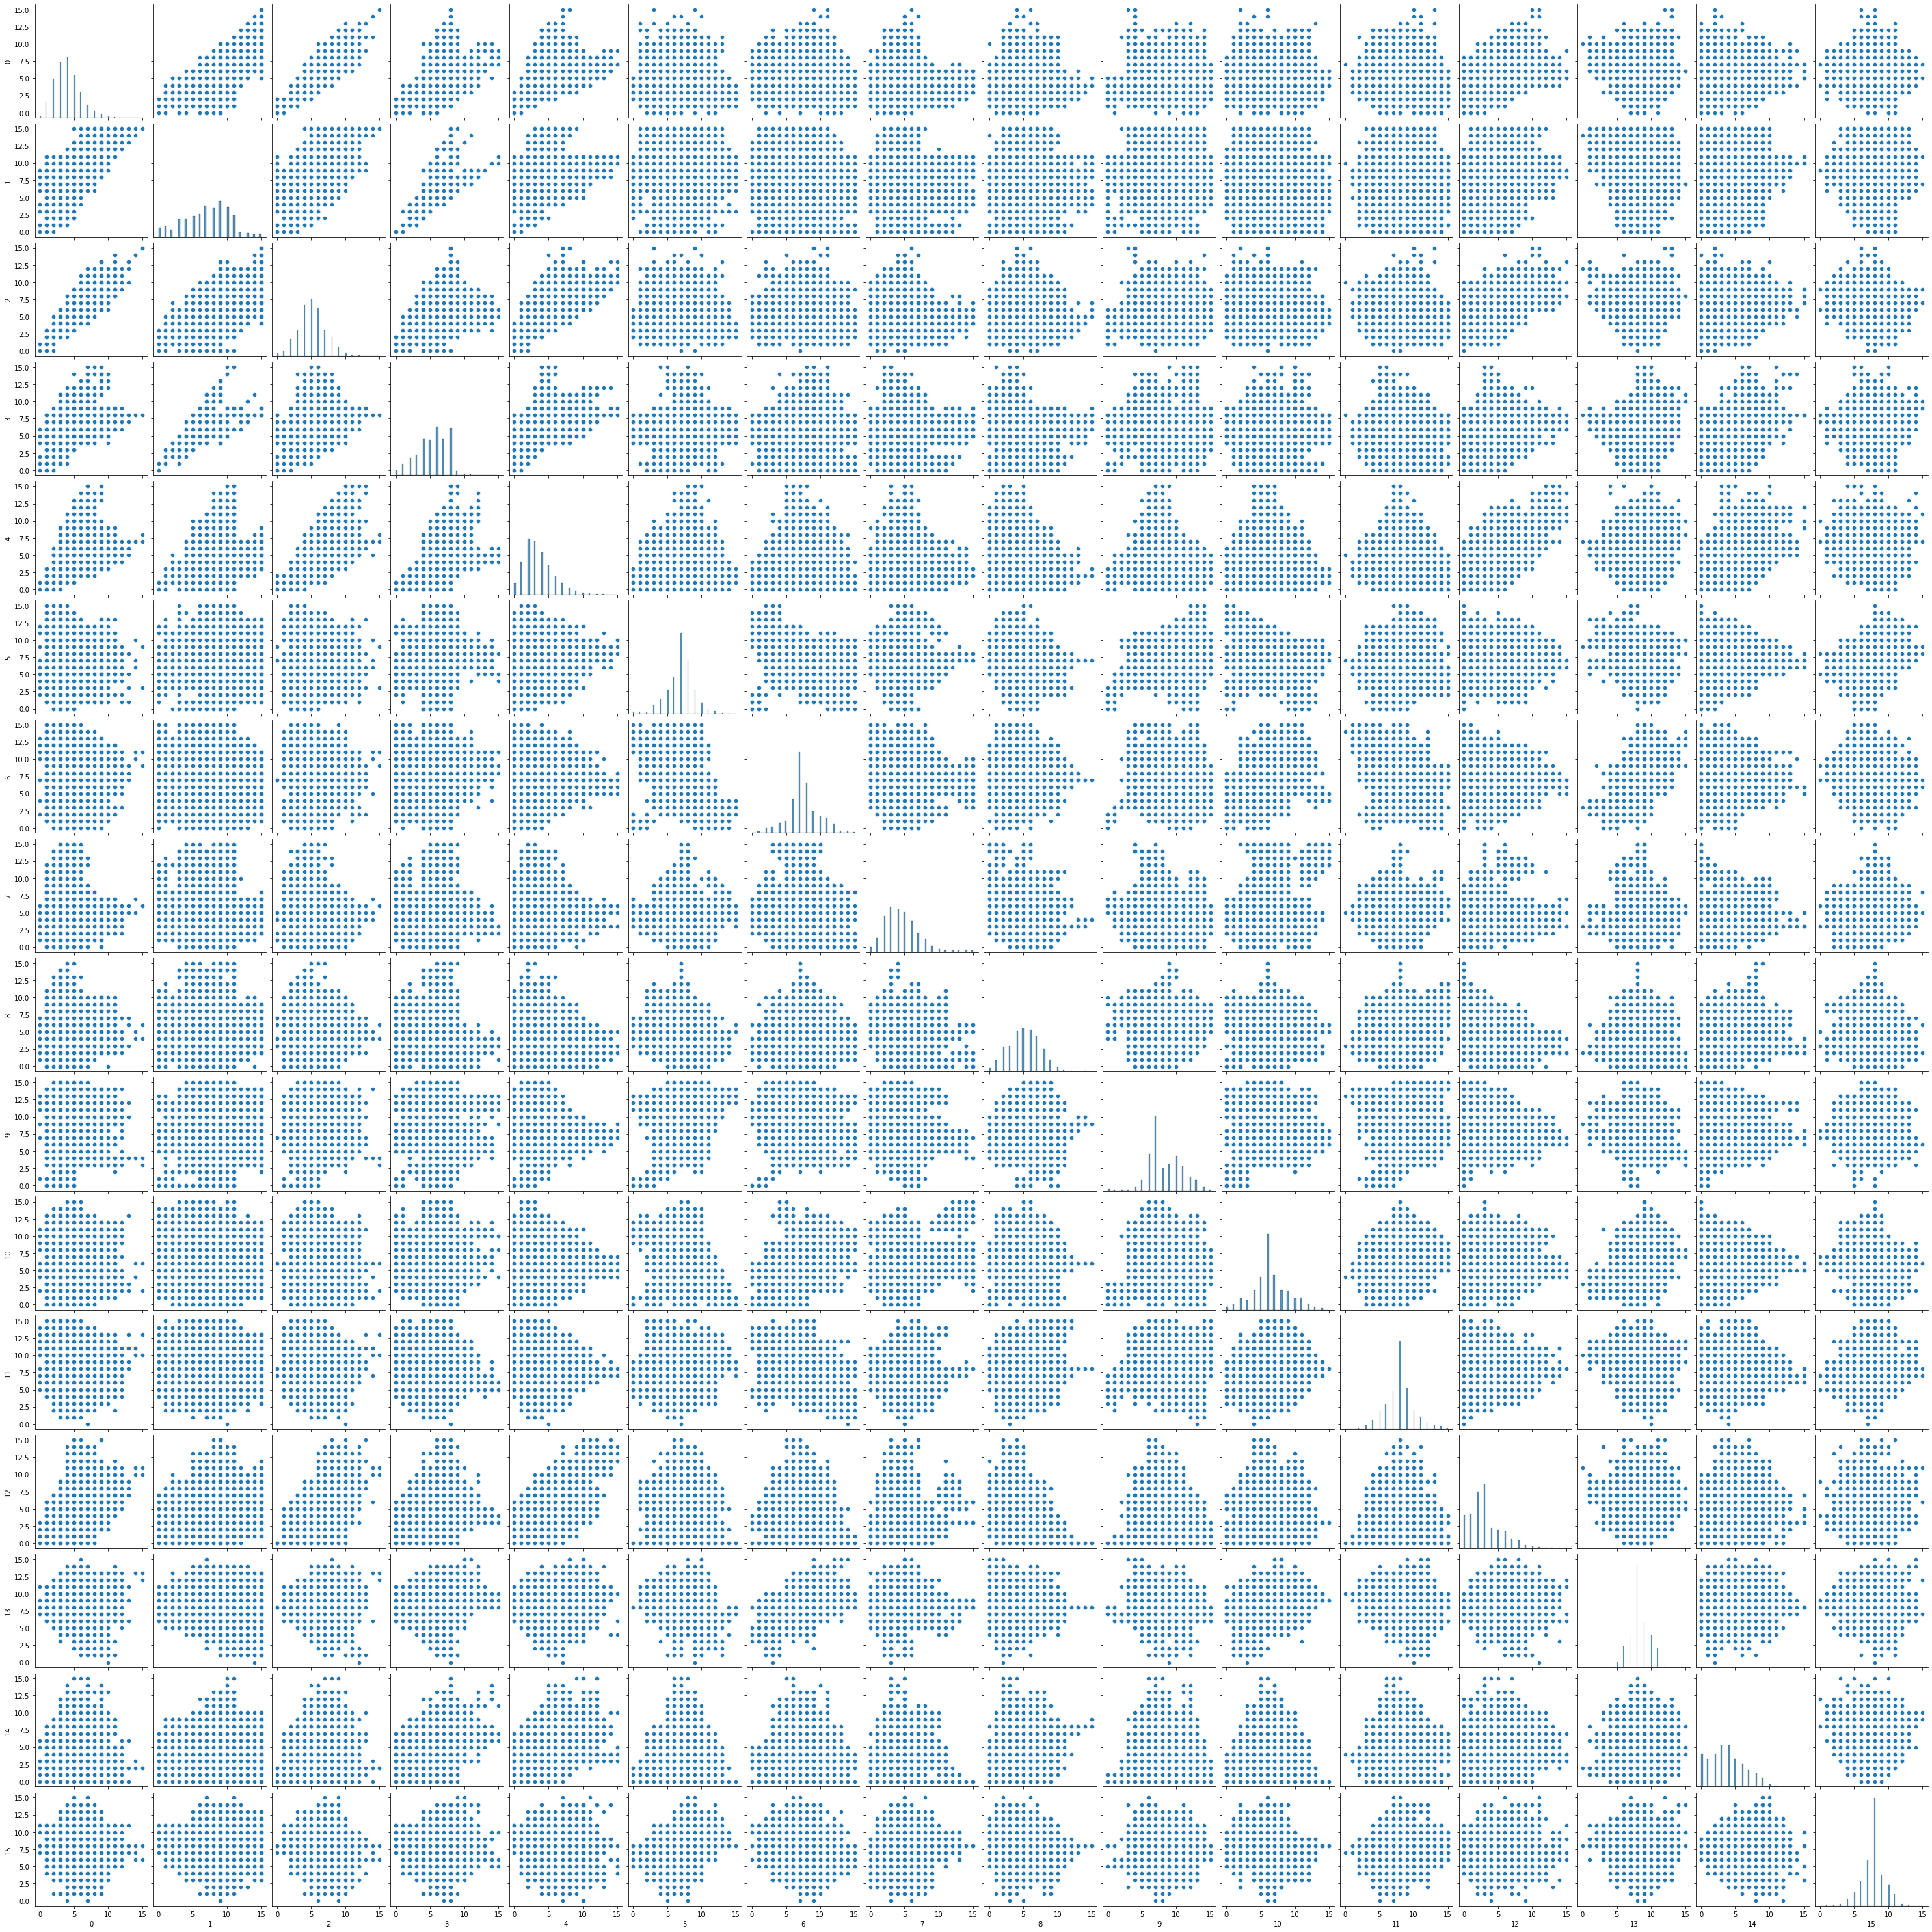

In [3]:
# Create a pairplot
df = pd.DataFrame(dataset)
sns.pairplot(df)
p= plt.show()

## Train-test split

Now we split sample into train and test subsets. You can play with the train-test percentage split (`test_size`, initially 40%). 

In [56]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(dataset, output, 
                                                test_size=0.3, 
                                                random_state=2)

print("Training dataset size: ", len(trainX))
print("Test dataset size: ", len(testX))

Training dataset size:  14000
Test dataset size:  6000


## Set up the Neural Network

The example below features a simple sequential (perceptron-type) Neural Network with:

* Input layer with 16 neurons (`input_dim`), corresponding to the 16 features of the generated dataset
* Hidden layers (configure as needed)
* Output layer with five neurons (binary encoding of the letters)

Notice that we use the "Binary Accuracy" metrics and the "Binary Crossentropy" loss. The metrics used affects significantly the result.

In [57]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

np.random.seed(10)
my_NN = Sequential() # create model

# First layer, set the input_dim to the number of features
my_NN.add(Dense(16, input_dim=16, activation='sigmoid')) # hidden layer

# More hidden layers
my_NN.add(Dense(64, activation='relu')) # hidden layer
my_NN.add(Dense(64, activation='relu')) # hidden layer


 # hidden layer

# Output layer
my_NN.add(Dense(5, activation='sigmoid')) # output layer

# Compile and define the loss function
my_NN.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## Train the network

Train in batches of data and collect accuracy for train and test datasets at each successive stage.

In [58]:
train_loss= []
train_acc= []
test_loss= []
test_acc= []

# Iterate for batches of epochs and collect status for train and test
for step in range(100):
    if step%10==0:
        print("Batch ",step)
    
    # verbose=0 suppresses the file writing message
    my_NN_fitted = my_NN.fit(trainX, trainy, epochs=100, 
                             verbose=0, batch_size=trainX.shape[0])
    
    # Collect performance information for train and test
    perf= my_NN.evaluate(trainX, trainy, verbose=0)
    train_loss.append(perf[0])
    train_acc.append(perf[1])
    
    perf= my_NN.evaluate(testX, testy, verbose=0)
    test_loss.append(perf[0])
    test_acc.append(perf[1])

Batch  0
Batch  10
Batch  20
Batch  30
Batch  40
Batch  50
Batch  60
Batch  70
Batch  80
Batch  90


Plot curves

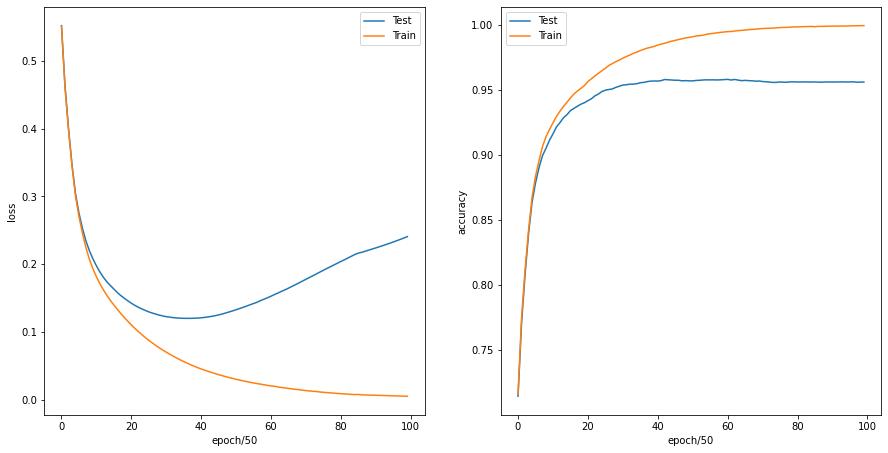

In [59]:
fig = plt.figure(frameon=False)
fig.set_size_inches(15,7.5)

# loss
plt.subplot(1,2,1)
plt.xlabel("epoch/50")
plt.ylabel("loss")
plt.plot(test_loss, label="Test")
plt.plot(train_loss, label="Train")
plt.legend()

# accuracy
plt.subplot(1,2,2)
plt.xlabel("epoch/50")
plt.ylabel("accuracy")
plt.plot(test_acc, label="Test")
plt.plot(train_acc, label="Train")
plt.legend()

p= plt.show()

## Analyze the Neural Network output

Compare required vs predicted output: count correct recognitions of letters.

In [60]:
# Predict output for test dataset
NN_out= my_NN.predict(testX, verbose=0)

# Function to decode output
def to_letter_code(bin_out):
    """Convert binary encoding output into a letter code"""
    rounded= ""
    for val in bin_out:
        rounded= rounded+str(int(round(val)))
    
#     return chr(int(rounded,2)+65)
    return int(rounded,2)
    
total= 0
correct= 0
for req,pred in zip(testy,NN_out):
    if to_letter_code(req)==to_letter_code(pred):
        correct+=1
    total+=1

print("Total:  ", total)
print("Correct: {:d} ({:.2f}%)".format(correct,100.*correct/total))


Total:   6000
Correct: 5136 (85.60%)


Confusion matrix

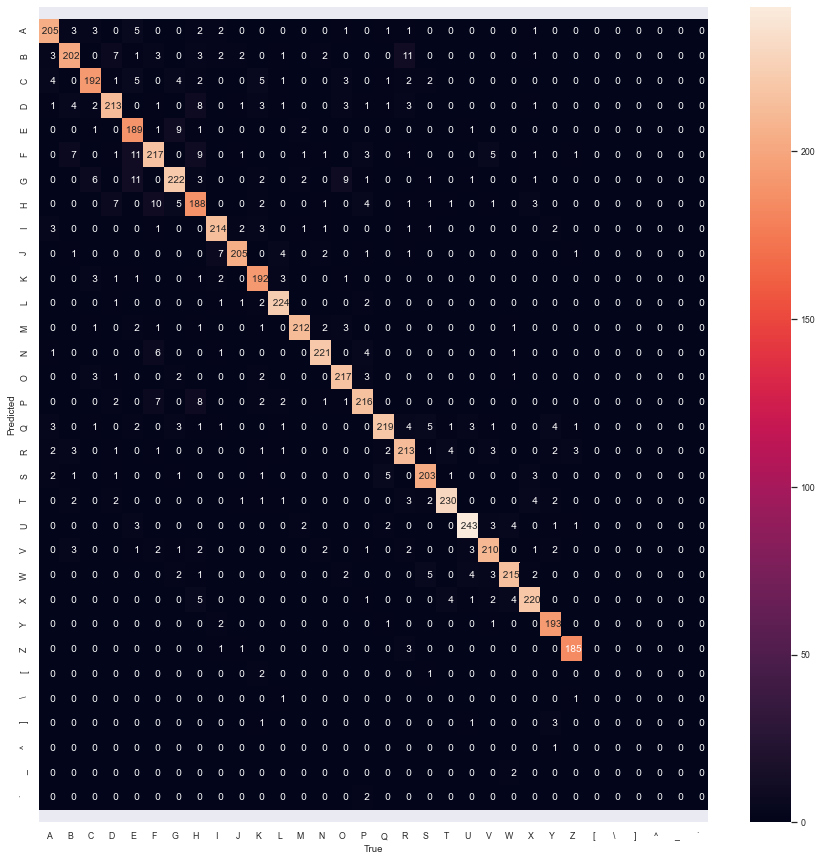

In [76]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate list of true-predicted letter codes
true= [to_letter_code(val) for val in testy]
pred= [to_letter_code(val) for val in NN_out]

# Generate confusion matrix
CM= confusion_matrix(pred,true)

# Plot heatmap
df_cm = pd.DataFrame(CM, range(32), range(32))
t_labels= [ chr(val+65) for val in range(0,32)]

plt.figure(figsize=(15,15))

sn.set(font_scale=0.8) # for label size
HM= sn.heatmap(df_cm, annot=True, annot_kws={"size":10}, fmt="4d")
HM.set_yticklabels(t_labels)
HM.set_xticklabels(t_labels)

# Patch to avoid cut in top/bottom; see https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()